# Multi-object Photometry

In this section we demonstrate how to preform photometry on multiple objects in an image. We choose a faint group of galaxies and run the photometry steps as described in the [Photometry](./photometry_and_petrosian.ipynb#Photometry) section.

## Loading Example Data

The following data is a cutout of a group of faint galaxies in Abell 2744. The original data was aquired by the [Hubble Frontier Fields](https://frontierfields.org) team via the WFC3 instrument in the `F105W` filter and can be dirctly downloaded from the [Mikulski Archive for Space Telescopes](https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0/hlsp_frontier_hst_wfc3-60mas_abell2744_f105w_v1.0_drz.fits). 

We first use `astropy`'s ``CCDData`` to load the example data and visualize it through `matplotlib`.

In [1]:
from astropy.nddata import CCDData

image = CCDData.read('data/abell_2744_group_of_galaxies_f105w.fits.gz')

In [2]:
# Hidden cell

%matplotlib inline

# Stop Fit Model to Data section warnings
import warnings
warnings.filterwarnings('ignore', append=True)

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'
#plt.rcParams.update({'font.size': 17})

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def savefig(filename):
    plt.savefig("plots/"+filename, dpi=70, bbox_inches = 'tight', pad_inches = 0.1)

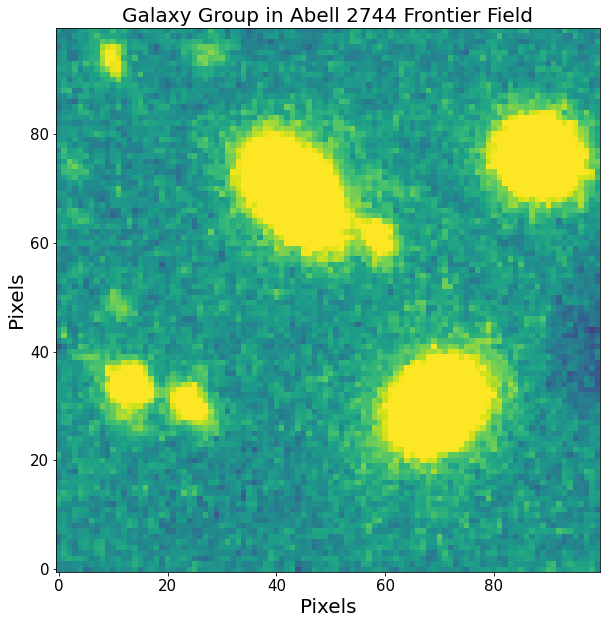

In [4]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['image.origin'] = 'lower'

vmax =  0.01 # Use the image std as max and min of all plots 
vmin = - vmax 

plt.imshow(image.data, vmin=vmin, vmax=vmax)
plt.title("Galaxy Group in Abell 2744 Frontier Field")
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

## Make Source Catalog 

We will use the sigma clipped std as a threshold at the segmentation and deblending steps.


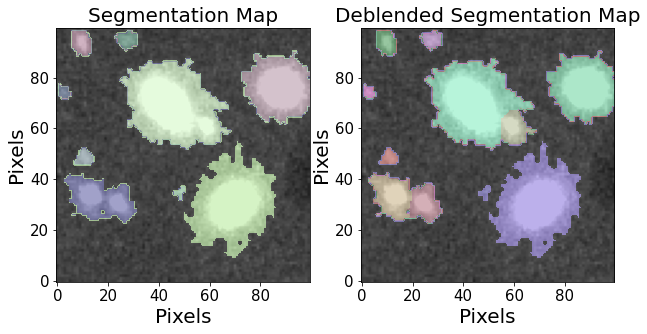

Num of Targets: 11


In [5]:
from petrofit.segmentation import make_catalog, plot_segments
from astropy.stats import sigma_clipped_stats, sigma_clip

# Compute stats for threshold
image_mean, image_median, image_stddev = sigma_clipped_stats(image.data, sigma=3)

# Define threshold
threshold = image_stddev 

# Define smoothing kernel
kernel_size = 3
fwhm = 3

# Min Source size (area)
npixels = 4**2


cat, segm, segm_deblend = make_catalog(    
    image.data, 
    threshold=threshold,
    wcs=image.wcs,
    deblend=True,                 
    kernel_size=kernel_size,                  
    fwhm=fwhm, 
    npixels=npixels,
    contrast=0.00,
    plot=True, vmax=vmax, vmin=vmin
)

plt.show()

# Display source properties
print("Num of Targets:", len(cat))

## Photometry Loop

We define the list of aperture radii and proceed to the photometry step. In this case, instead of selecting a source, we loop through the source catalog and preform photometry on each object. After constructing the photometry we create a ` Petrosian` object for the source. We save the `Petrosian` in a python dictionary (`petrosian_properties`) for later use.

In [6]:
from petrofit.photometry import source_photometry
from petrofit.petrosian import Petrosian, PetrosianCorrection
from petrofit.photometry import make_radius_list

max_pix=35

r_list = make_radius_list(
    max_pix=max_pix, # Max pixel to go up to
    n=max_pix # the number of radii to produce 
)


petrosian_properties = {}

for idx, source in enumerate(cat):
    
    # Photomerty 
    flux_arr, area_arr, error_arr = source_photometry(

        # Inputs 
        source, # Source (`photutils.segmentation.catalog.SourceCatalog`)
        image.data, # Image as 2D array 
        segm_deblend, # Deblended segmentation map of image
        r_list, # list of aperture radii  

        # Options 
        cutout_size=max(r_list)*2, # Cutout out size, set to double the max radius  
        bkg_sub=True, # Subtract background  
        sigma=1, sigma_type='clip', # Fit a 2D plane to pixels within 1 sigma of the mean
        plot=False, vmax=vmax, vmin=vmin, # Show plot with max and min defined above
    )
    plt.show()
    
    p = Petrosian(r_list, area_arr, flux_arr)
    
    petrosian_properties[source] = p
    
print("Completed for {} Sources".format(len(petrosian_properties)))

Completed for 11 Sources


## Compute Total Mags 

We compute the total magnitudes of the sources by looping through their ` Petrosian` objects. We use the ` flux_to_abmag` function to convert the total flux to AB mags of each object.

In [7]:
import numpy as np 
from petrofit.photometry import flux_to_abmag

mag_list = []

for source in petrosian_properties:
    
    # Get Petrosian
    p = petrosian_properties[source]
    
    # Compute HST Flux -> mags for total_flux
    mag = flux_to_abmag(p.total_flux, image.header)
    
    # Add to mag list
    mag_list.append(mag)

# Convert mag_list to array 
mag_list = np.array(mag_list)

mag_list

array([23.82381787, 29.52559858, 28.51023948, 24.05387849, 30.42062918,
       27.50426019, 29.35501043, 26.46159354, 25.7798995 , 26.41250124,
       23.58467512])

## Photometry Catalog

We construct and save a photometry catalog with the magnitudes we computed. To construct the table, we first use the `SourceCatalog.to_table()` function that returns an `astropy` `table`. This will include important info about each source. We then add a new column (`MAG_F105W`) with the total mags we computed. 

In [8]:
# Segmentation catalog to astropy table.
photo_cat = cat.to_table()

# Add new column with mags.
photo_cat.add_column(mag_list, index=4, name='MAG_F105W')

# Save to file.
#photo_cat.write('temp/example_photo_cat.csv', overwrite=True)

photo_cat

label,xcentroid,ycentroid,sky_centroid,MAG_F105W,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float64,float64,float64
1,69.41103062880637,30.315947373809582,"3.5792221956114045,-30.380186164993187",23.823817869414693,50,86,9,55,1007.0,6.816977087043578,5.467045344322998,52.36545051567701,0.5973575690255633,-0.0007741072,0.07670669,0.0,10.142585,nan,10.705617083958787,nan
2,48.415250242542356,34.76667790827527,"3.579627825154714,-30.380112001716117",29.525598584912757,46,50,32,37,18.0,1.5351974395820278,1.1361603796017512,59.54773931379103,0.6725249652150865,0.00088044006,0.00495786,0.0,0.048716225,nan,0.27298830675668817,nan
3,10.723675362202394,48.36581061991497,"3.5803560115860167,-30.379885374267737",28.510239482499028,7,14,46,52,40.0,1.7915174219079304,1.6071530100776072,12.894816092830986,0.44184712840694945,0.0007765131,0.006208378,0.0,0.14133699,nan,0.365881439324934,nan
4,87.96607120918883,75.75285991459342,"3.5788637567041843,-30.379428868007604",24.053878489090614,73,99,62,90,560.0,4.551456896331602,4.284626780617939,-33.19451883508707,0.33736257126099184,0.0003960066,0.10125063,0.0,8.023693,nan,8.203110323398937,nan
5,2.6388865818851475,74.12642892367425,"3.580512216832037,-30.3794560352708",30.420629178108744,1,5,72,77,22.0,1.5010430786811113,1.064613878363206,-55.7265711153266,0.7049576666823867,0.0014598162,0.0058039473,0.0,0.070067465,nan,0.09460372750209241,nan
6,9.595897953226478,93.77137025796466,"3.5803778219391056,-30.379128615335496",27.50426018600516,6,13,89,98,69.0,2.316568681450761,1.5831936367641857,-68.6151919360393,0.730023688020057,-0.0003018236,0.012467582,0.0,0.32430932,nan,0.43912998155529215,nan
7,27.47085460922016,94.85234655402142,"3.5800324920692135,-30.379110587833296",29.35501042668036,23,31,91,98,47.0,1.9955255709614443,1.5845356770020202,0.9234764529732234,0.607859911508739,0.0010049416,0.0065371594,0.0,0.16566622,nan,0.20697125019559204,nan
8,24.307434302087866,30.35392939609522,"3.5800935719841864,-30.380185563912143",26.461593539188648,18,31,23,38,144.0,3.0245707261258468,2.4202134731021587,-64.46278250057281,0.5997544245273903,0.00017471019,0.026761448,0.0,0.95649534,nan,1.1915633946894406,nan


# Simultaneous Fitting

In this section we explore how to make compound models that can be used to describe multiple objects in an image. We use the same dataset as the [Multi-object Photometry section](#Multi-object-Photometry) to fit the nine faint sources with Sersic profiles. 

## Make Individual Models

To do this we loop through the sources and construct `astropy` ` Sersic2D` models for source as described in the [AstroPy Sersic Model sction](./fitting.ipynb#AstroPy-Sersic-Model). We also make initial guesses of the paramters as described in the [Estimating Sersic Parameters](./fitting.ipynb#Estimating-Sersic-Parameters) section. At the end of each iteration, we add the newly constructed model in a list `model_list`.

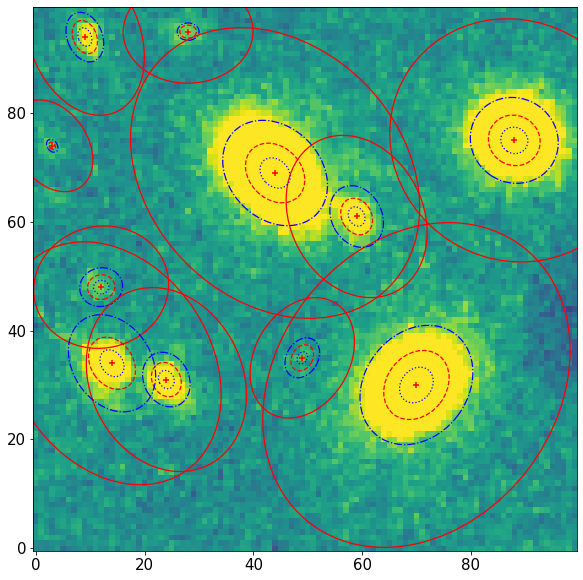

In [9]:
from petrofit.segmentation import get_source_ellip, get_source_elong, get_source_position, get_source_theta
from photutils.isophote import EllipseGeometry, Ellipse
from astropy.modeling import models 

# AstroPy Model List
model_list = []

# For each source
for source in list(petrosian_properties.keys()):
    
    # Get Petrosian
    p = petrosian_properties[source]
    
    # Estimate center 
    position = get_source_position(source)    
    x_0, y_0 = position
    
    # Estimate shape 
    elong = get_source_elong(source)
    ellip = get_source_ellip(source)
    theta = get_source_theta(source)
    
    # Estimate Sersic index
    n = 1
    
    # Estimate r_half_light
    r_eff = p.r_half_light
    
    # Estimate amplitude
    g = EllipseGeometry(x_0, y_0, 1., ellip, theta)
    ellipse = Ellipse(image.data, geometry=g)
    iso = ellipse.fit_isophote(r_eff)
    amplitude = iso.intens
    
    # Allow for 4 pixel center slack 
    center_slack = 4
    
    # Make astropy model
    sersic_model = models.Sersic2D(

            amplitude=amplitude,
            r_eff=r_eff,
            n=n,
            x_0=x_0,
            y_0=y_0,
            ellip=ellip, 
            theta=theta,

            bounds = {
                'amplitude': (0., None),
                'r_eff': (0, None),
                'n': (0, 10),
                'ellip': (0, 1),
                'theta': (-2*np.pi, 2*np.pi),
                'x_0': (x_0 - center_slack/2, x_0 + center_slack/2),
                'y_0': (y_0 - center_slack/2, y_0 + center_slack/2),
            },
    )
    
    # Add to model list 
    model_list.append(sersic_model)
    
    # Over-plot Petrosian radii 
    p.imshow(position=position, elong=elong, theta=theta, lw=1.25)

# Plot image of sources 
plt.imshow(image.data, vmax=vmax, vmin=vmin)
plt.show()

## Make Compound Model

To make a single compound model that represents all the sources of interest, we add up all the models. `astropy` models can be added like numbers or arrays, so we convert the model list to a `numpy` array and sum it. 


In [10]:
compound_model = np.array(model_list).sum()

compound_model

<CompoundModel(amplitude_0=0.02433386, r_eff_0=6.82636527, n_0=1., x_0_0=70., y_0_0=30., ellip_0=0.19802498, theta_0=0.91394953, amplitude_1=0.00206355, r_eff_1=2.5555111, n_1=1., x_0_1=49., y_0_1=35., ellip_1=0.25992556, theta_1=1.03930411, amplitude_2=0.00332594, r_eff_2=2.5205041, n_2=1., x_0_2=12., y_0_2=48., ellip_2=0.10290964, theta_2=0.225057, amplitude_3=0.03232745, r_eff_3=4.84496899, n_3=1., x_0_3=88., y_0_3=75., ellip_3=0.05862521, theta_3=-0.57935365, amplitude_4=0.00467585, r_eff_4=0.73514703, n_4=1., x_0_4=3., y_0_4=74., ellip_4=0.29075062, theta_4=-0.97261215, amplitude_5=0.00629133, r_eff_5=3.17163433, n_5=1., x_0_5=9., y_0_5=94., ellip_5=0.31657816, theta_5=-1.19756102, amplitude_6=0.00504217, r_eff_6=1.51930386, n_6=1., x_0_6=28., y_0_6=95., ellip_6=0.20595571, theta_6=0.0161177, amplitude_7=0.01091044, r_eff_7=3.26965393, n_7=1., x_0_7=24., y_0_7=31., ellip_7=0.19981588, theta_7=-1.1250878, amplitude_8=0.00643755, r_eff_8=5.16003201, n_8=1., x_0_8=14., y_0_8=34., ell

## Make PSFModel

Now that we have a single model that represents all the sources, we can create a `PSFModel` with the appropriate parameters. We load a PSF as described in the [PSF section](./fitting.ipynb#Estimating-Sersic-Parameters) of the fitting documentation. We then wrap the compound model and PSF using `PSFModel`. We specify an oversampling factor 4 to account for poor CCD sampling.

**Load and Normalize PSF**


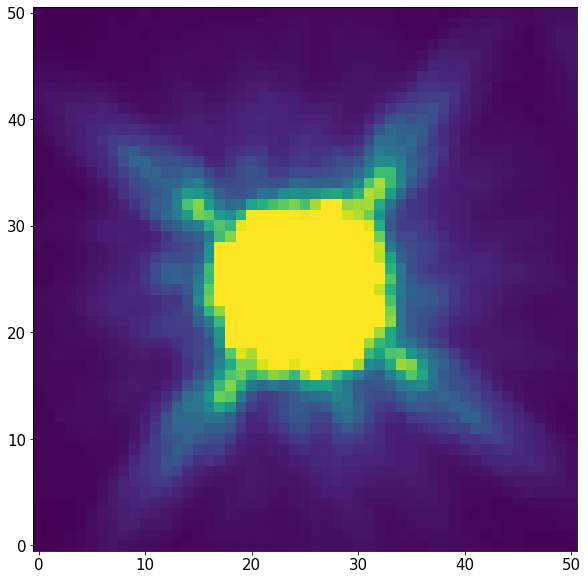

In [11]:
from astropy.io import fits

PSF = fits.getdata('data/f105w_psf.fits.gz')
PSF = PSF / PSF.sum()

plt.imshow(PSF, vmin=0, vmax=PSF.std()/10)

**PSFModel**

In [12]:
from petrofit.models import PSFModel

psf_sersic_model = PSFModel.wrap(compound_model, psf=PSF, oversample=4)

psf_sersic_model.fixed['psf_pa'] = True

## Fit Model to Data

We fit the compound model using a Levenberg-Marquardt algorithm and save the returned optimized copy of the fitted model in  `fitted_model`. Since this the compound model is composed of many parameters, we may see `astropy` warnings when the fitter explores parameters that cause issues, such as division by zero.

In [35]:
%%time

from petrofit.fitting import fit_model

fitted_model, _ = fit_model(
    image.data, psf_sersic_model,
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

CPU times: user 6min 17s, sys: 1.11 s, total: 6min 18s
Wall time: 6min 17s


## Generate Model Image

To generate a model image we use the `model_to_image` utility function. This function allows us to define the center of the model image and the side length of the image.

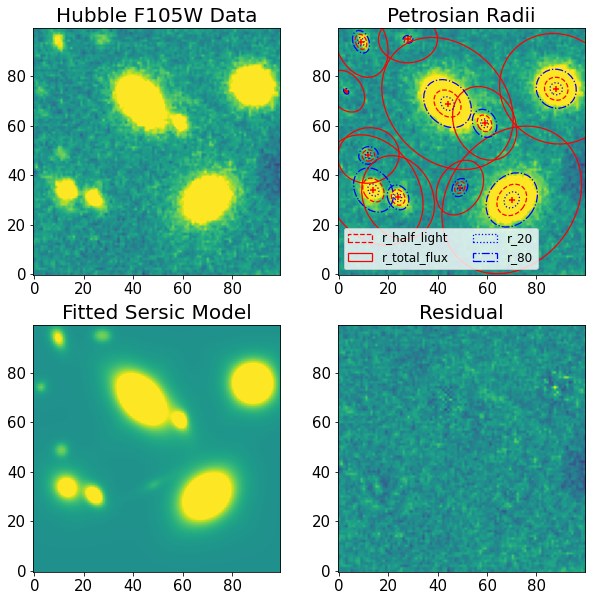

In [14]:
from petrofit.fitting import model_to_image

# Make Model Image
# ----------------

# Set the size of the model image equal to the original image
full_fitted_image_size = image.data.shape[0]

# Center the model image at the center of the original image
# so the two images cover the same window
full_fitted_image_center = full_fitted_image_size // 2

# Generate a model image from the model
fitted_model_image = model_to_image(
    full_fitted_image_center,
    full_fitted_image_center,
    full_fitted_image_size,
    fitted_model
)

# Plot Model Image
# ----------------

fig, ax = plt.subplots(2, 2)

# Plot raw data
ax[0, 0].imshow(image.data, vmin=vmin, vmax=vmax)
ax[0, 0].set_title("Hubble F105W Data")

# Plot Petrosian radii
plt.sca(ax[0, 1])
for i, source in enumerate(petrosian_properties):
    p = petrosian_properties[source]
    
    position = get_source_position(source)    
    x_0, y_0 = position
    
    elong = get_source_elong(source)
    ellip = get_source_ellip(source)
    theta = get_source_theta(source)
    
    p.imshow(position=position, elong=elong, theta=theta, lw=1.25)
    if i == 0:
        plt.legend(ncol=2)
ax[0, 1].imshow(image.data, vmin=vmin, vmax=vmax)
ax[0, 1].set_title("Petrosian Radii")

# Plot Model Image
ax[1, 0].imshow(fitted_model_image, vmin=vmin, vmax=vmax)
ax[1, 0].set_title("Fitted Sersic Model")

# Plot Residual
ax[1, 1].imshow(image.data - fitted_model_image, vmin=vmin, vmax=vmax)
ax[1,1].set_title("Residual")

plt.show()

## Analysis of Background

We can now create a background image using the residual and preform some statistical  analysis on it.

noise_mean = 5.5682827338328787e-05
noise_sigma = 0.0013783332676002675
noise_3_sigma = 0.004134999802800803


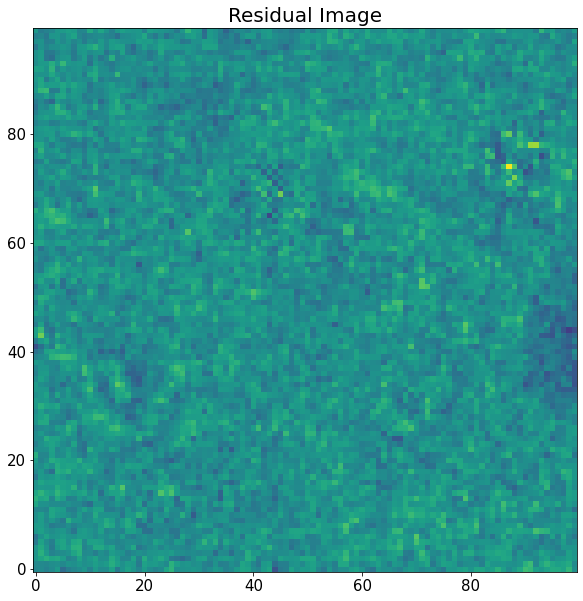

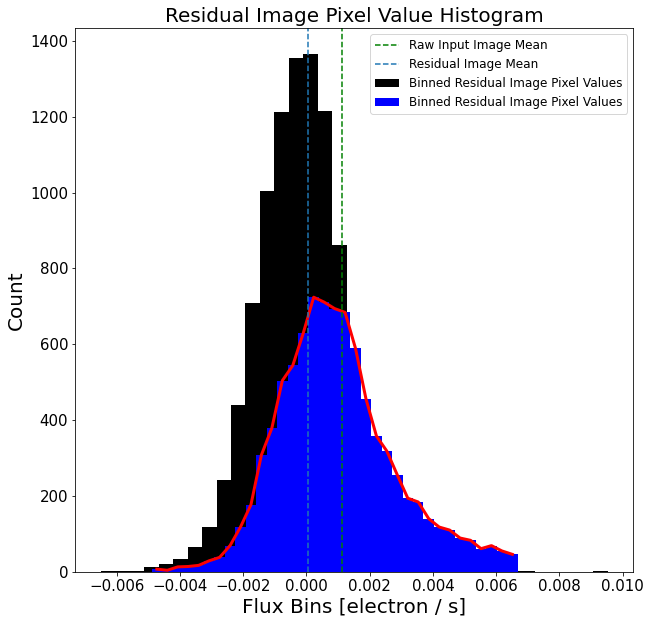

In [15]:
# Define background image
background_image = image.data - fitted_model_image

# Compute stats
# -------------

noise_mean = background_image.mean()
noise_sigma = background_image.std()
noise_3_sigma = noise_sigma * 3.
noise_8_sigma = noise_sigma * 8.

print("noise_mean = {}".format(noise_mean))
print("noise_sigma = {}".format(noise_sigma))
print("noise_3_sigma = {}".format(noise_3_sigma))

# Plots
# -----

plt.imshow(image.data - fitted_model_image, vmin=vmin, vmax=vmax)
plt.title('Residual Image')
plt.show()



n, bins, patches = plt.hist(background_image.flatten(), bins=35, align='left', 
                            color='black', label="Binned Residual Image Pixel Values")

n, bins, patches = plt.hist(sigma_clip(image.data, sigma=3).flatten(), bins=35, align='left', 
                            color='blue', label="Binned Residual Image Pixel Values")


plt.plot(bins[:-1], n, c='r', linewidth=3)
plt.axvline(image_mean, label="Raw Input Image Mean", c='g',linestyle="--")
plt.axvline(noise_mean, label="Residual Image Mean", linestyle="--")
sigma_clip(image.data, sigma=3)


plt.xlabel('Flux Bins [{}]'.format(str(image.unit)))
plt.ylabel('Count')
plt.title('Residual Image Pixel Value Histogram')
plt.legend()

plt.show()

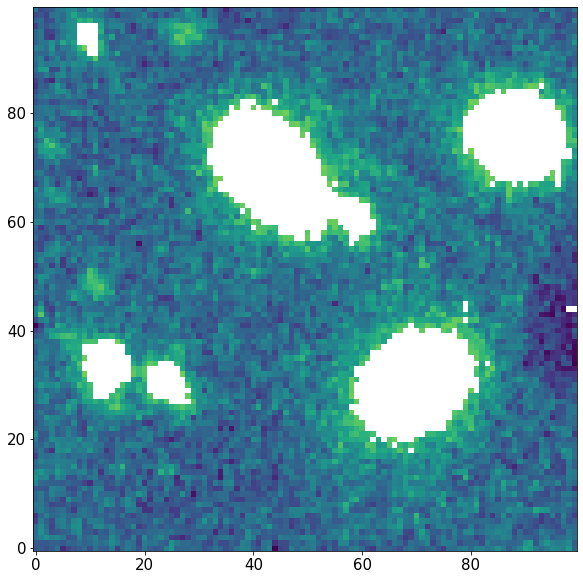

In [16]:
plt.imshow(sigma_clip(image.data, sigma=3), vmax=vmax)



Now we see the residual image mean is near that is near the mean of the noise distribution, we can make a segmentation map using the residual image 3-sigma as the detection threshold. Notice how some of the sources we were able to fit were below the 3-sigma estimate of the background (residual image). 

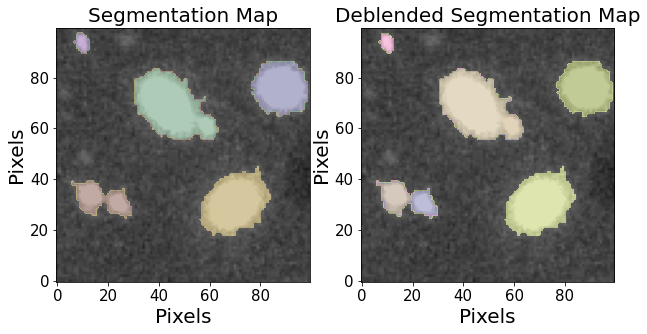

Num of Targets: 7


In [17]:
new_threshold = noise_3_sigma

new_cat, new_segm, new_segm_deblend = make_catalog(    
    image.data, 
    threshold=new_threshold,
    wcs=image.wcs,
    deblend=True,                 
    kernel_size=kernel_size,                  
    fwhm=fwhm, 
    npixels=npixels,
    contrast=0.00,
    plot=True, vmax=vmax, vmin=vmin
)

plt.show()

# Display source properties
print("Num of Targets:", len(new_cat))

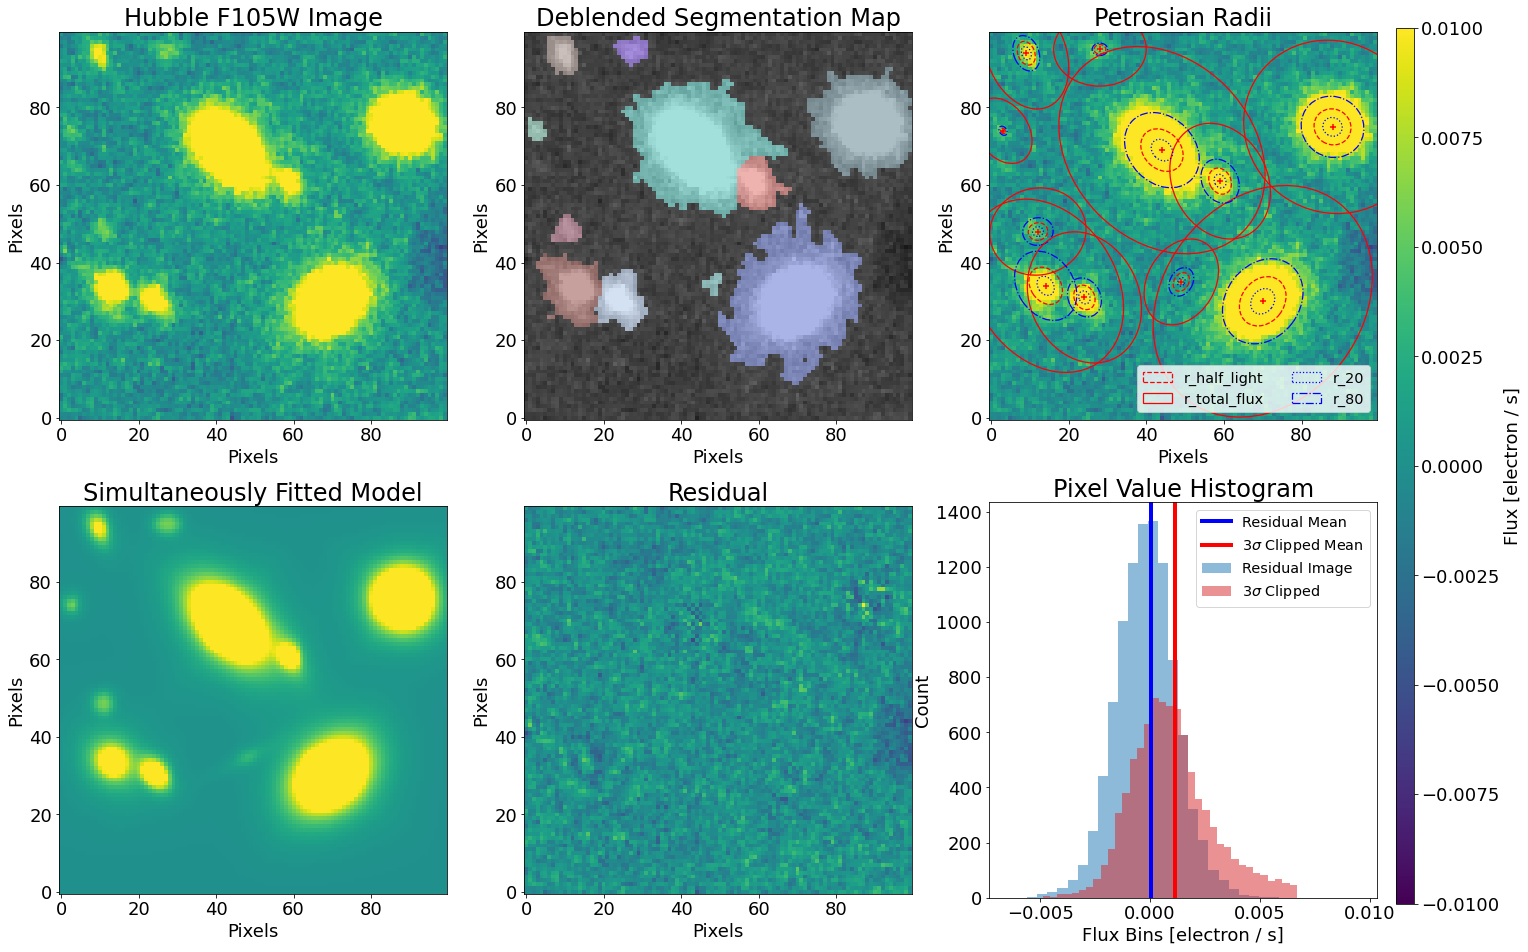

In [34]:
from petrofit.fitting import model_to_image
from petrofit.segmentation import plot_segments

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
factor = 1.2
plt.rc('axes', titlesize=BIGGER_SIZE*factor)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE*factor)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE*factor)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE*factor)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE*factor)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE*factor*2)  # fontsize of the figure title


# Make Model Image
# ----------------

# Set the size of the model image equal to the original image
full_fitted_image_size = image.data.shape[0]

# Center the model image at the center of the original image
# so the two images cover the same window
full_fitted_image_center = full_fitted_image_size // 2

# Generate a model image from the model
fitted_model_image = model_to_image(
    full_fitted_image_center,
    full_fitted_image_center,
    full_fitted_image_size,
    fitted_model
)

# Plot Model Image
# ----------------

figsize = [8*3.2, 8*2]
fig, ax = plt.subplots(2, 3, figsize=figsize)

# Plot raw data
plt.sca(ax[0, 0])
ax[0, 0].imshow(image.data, vmin=vmin, vmax=vmax)
plt.title("Hubble F105W Image")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

# Plot Petrosian radii
plt.sca(ax[0, 1])
plot_segments(segm_deblend, image.data, vmin=vmin, vmax=vmax)
plt.title("Deblended Segmentation Map")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

# Plot Petrosian radii
plt.sca(ax[0, 2])
for i, source in enumerate(petrosian_properties):
    p = petrosian_properties[source]
    
    position = get_source_position(source)    
    x_0, y_0 = position
    
    elong = get_source_elong(source)
    ellip = get_source_ellip(source)
    theta = get_source_theta(source)
    
    p.imshow(position=position, elong=elong, theta=theta, lw=1.25)
    if i == 0:
        plt.legend(ncol=2)
im = ax[0, 2].imshow(image.data, vmin=vmin, vmax=vmax)
ax[0, 2].set_title("Petrosian Radii")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

# Plot Model Image
plt.sca(ax[1, 0])
ax[1, 0].imshow(fitted_model_image, vmin=vmin, vmax=vmax)
ax[1, 0].set_title("Simultaneously Fitted Model")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

# Plot Residual
plt.sca(ax[1, 1])
ax[1, 1].imshow(image.data - fitted_model_image, vmin=vmin, vmax=vmax)
ax[1,1].set_title("Residual")
plt.xlabel("Pixels")
plt.ylabel("Pixels")

plt.sca(ax[1, 2])
background_image = image.data - fitted_model_image

# Compute stats
# -------------

noise_mean = background_image.mean()
noise_sigma = background_image.std()
noise_3_sigma = noise_sigma * 3.
noise_8_sigma = noise_sigma * 8.


n, bins, patches = plt.hist(background_image.flatten(), bins=35, align='left', 
                            color='tab:blue', label="Residual Image", alpha=0.5)
#plt.plot(bins[:-1], n, c='tab:blue', linewidth=3, linestyle='--')
sigma_clip_image = sigma_clip(image.data, sigma=3)
n, bins, patches = plt.hist(sigma_clip_image.flatten(), bins=35, align='left', 
                            color='tab:red', label="3$\sigma$ Clipped", alpha=0.5)
#plt.plot(bins[:-1], n, c='tab:red', linewidth=3, linestyle='--')

plt.axvline(noise_mean, label="Residual Mean", linestyle="-",linewidth=4, c='blue')
plt.axvline(sigma_clip_image.mean(), label="3$\sigma$ Clipped Mean", c='red',linestyle="-",linewidth=4)

#plt.xlim(-0.007, 0.014)
#plt.ylim(0, 1500)


plt.xlabel('Flux Bins [{}]'.format(str(image.unit)))
plt.ylabel('Count')
plt.title('Pixel Value Histogram')
plt.legend(loc='upper right')



fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, 0.12, 0.01, 0.76])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('Flux [electron / s]', rotation=90)

savefig('multi_galaxy.png')

plt.show()


#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



In [19]:
photo_cat

label,xcentroid,ycentroid,sky_centroid,MAG_F105W,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,"deg,deg",,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float64,float64,float64
1,69.41103062880637,30.315947373809582,"3.5792221956114045,-30.380186164993187",23.823817869414693,50,86,9,55,1007.0,6.816977087043578,5.467045344322998,52.36545051567701,0.5973575690255633,-0.0007741072,0.07670669,0.0,10.142585,nan,10.705617083958787,nan
2,48.415250242542356,34.76667790827527,"3.579627825154714,-30.380112001716117",29.525598584912757,46,50,32,37,18.0,1.5351974395820278,1.1361603796017512,59.54773931379103,0.6725249652150865,0.00088044006,0.00495786,0.0,0.048716225,nan,0.27298830675668817,nan
3,10.723675362202394,48.36581061991497,"3.5803560115860167,-30.379885374267737",28.510239482499028,7,14,46,52,40.0,1.7915174219079304,1.6071530100776072,12.894816092830986,0.44184712840694945,0.0007765131,0.006208378,0.0,0.14133699,nan,0.365881439324934,nan
4,87.96607120918883,75.75285991459342,"3.5788637567041843,-30.379428868007604",24.053878489090614,73,99,62,90,560.0,4.551456896331602,4.284626780617939,-33.19451883508707,0.33736257126099184,0.0003960066,0.10125063,0.0,8.023693,nan,8.203110323398937,nan
5,2.6388865818851475,74.12642892367425,"3.580512216832037,-30.3794560352708",30.420629178108744,1,5,72,77,22.0,1.5010430786811113,1.064613878363206,-55.7265711153266,0.7049576666823867,0.0014598162,0.0058039473,0.0,0.070067465,nan,0.09460372750209241,nan
6,9.595897953226478,93.77137025796466,"3.5803778219391056,-30.379128615335496",27.50426018600516,6,13,89,98,69.0,2.316568681450761,1.5831936367641857,-68.6151919360393,0.730023688020057,-0.0003018236,0.012467582,0.0,0.32430932,nan,0.43912998155529215,nan
7,27.47085460922016,94.85234655402142,"3.5800324920692135,-30.379110587833296",29.35501042668036,23,31,91,98,47.0,1.9955255709614443,1.5845356770020202,0.9234764529732234,0.607859911508739,0.0010049416,0.0065371594,0.0,0.16566622,nan,0.20697125019559204,nan
8,24.307434302087866,30.35392939609522,"3.5800935719841864,-30.380185563912143",26.461593539188648,18,31,23,38,144.0,3.0245707261258468,2.4202134731021587,-64.46278250057281,0.5997544245273903,0.00017471019,0.026761448,0.0,0.95649534,nan,1.1915633946894406,nan
